In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Battery_RUL.csv')

In [ ]:
df['Battery ID'] = 0
batteries = []
ID = 1
for rul in df['RUL']:
  batteries.append(ID)
  if rul == 0:
    ID +=1
    continue

df['Battery ID'] = batteries

In [ ]:
sensor_list = df.columns[1:-2]

In [ ]:
sensor_list

Index(['Discharge Time (s)', 'Decrement 3.6-3.4V (s)',
       'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)',
       'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)'],
      dtype='object')

In [ ]:
train_battery_ids = []
test_battery_ids = []
battery_ids = df['Battery ID'].unique()

for i in battery_ids:
  if i<9:
    train_battery_ids.append(i)

  else:
    test_battery_ids.append(i)

df_train = df[df['Battery ID'].isin(train_battery_ids)]
df_test =  df[df['Battery ID'].isin(test_battery_ids)]

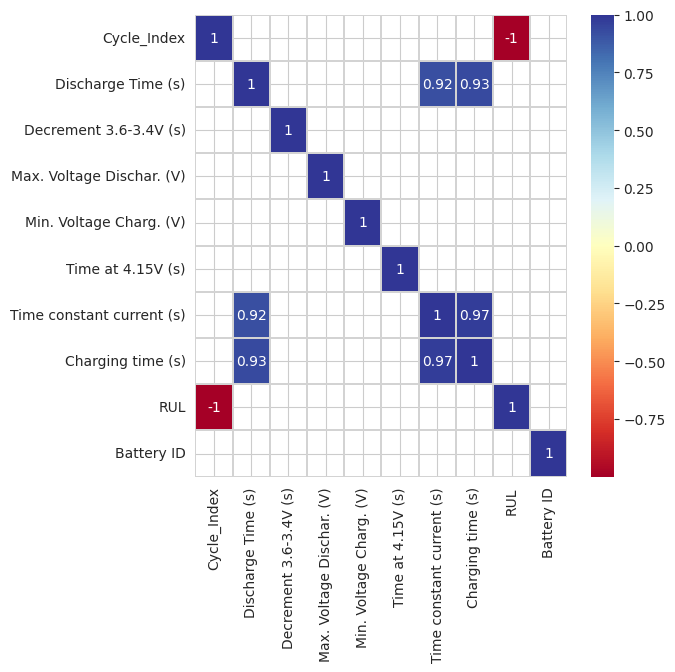

In [ ]:
plt.figure(figsize=(6, 6))
threshold = 0.90
sns.set_style('whitegrid', {"axes.facecolor": ".0"})
df_cluster2 = df_train.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws = {"s": 1}
sns.heatmap(df_cluster2, cmap ='RdYlBu', annot= True, mask = mask, linewidths = 0.2, linecolor='lightgrey').set_facecolor('white')

In [ ]:
import sys
!{sys.executable} -m pip install pandas-profiling

In [ ]:
from pandas_profiling import ProfileReport

<ipython-input-10-e2a33329b6f0>:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [ ]:
sens_const_values = []
for feature in list(sensor_list):
  try:
    if df_train[feature].min() == df_train[feature].max():
      sens_const_values.append(feature)

  except:
    pass

print(sens_const_values)
df_train.drop(sens_const_values, axis =1, inplace = True)
df_test.drop(sens_const_values, axis =1, inplace = True)

[]


<ipython-input-11-a3064696911d>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(sens_const_values, axis =1, inplace = True)
<ipython-input-11-a3064696911d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(sens_const_values, axis =1, inplace = True)


In [ ]:
cor_matrix = df_train[sensor_list].corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
corr_features = [column for column in upper_tri.columns if any(upper_tri[column]>0.95)]
print(corr_features)
df_train.drop(corr_features, axis =1, inplace = True)
df_test.drop(corr_features, axis =1, inplace = True)

['Charging time (s)']


<ipython-input-12-acbd5e555458>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool))
<ipython-input-12-acbd5e555458>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(corr_features, axis =1, inplace = True)
<ipython-input-12-acbd5e555458>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

In [ ]:
list(df_train)

['Cycle_Index',
 'Discharge Time (s)',
 'Decrement 3.6-3.4V (s)',
 'Max. Voltage Dischar. (V)',
 'Min. Voltage Charg. (V)',
 'Time at 4.15V (s)',
 'Time constant current (s)',
 'RUL',
 'Battery ID']

In [ ]:
feature_names =  df_train.iloc[: , 0:-2]

In [ ]:
list(feature_names)

['Cycle_Index',
 'Discharge Time (s)',
 'Decrement 3.6-3.4V (s)',
 'Max. Voltage Dischar. (V)',
 'Min. Voltage Charg. (V)',
 'Time at 4.15V (s)',
 'Time constant current (s)']

In [ ]:
import time
#model_performance = pd.DataFrame(columns = ['r-Squared', 'RMSE', 'total time'])

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, accuracy_score

import sklearn
from sklearn.metrics import mean_squared_error, r2_score

model_performance = pd.DataFrame(columns=['R2', 'RMSE', 'time to train', 'time to predict', 'total time'])

def R_squared(y_true, y_pred):
  SS_res = K.sum(K.square(y_true - y_pred))
  SS_tot = K.sum(K.square(y_true - K.means(y_true)))
  return 1 - SS_res/(SS_tot + K.epsilon())

In [ ]:
X_train = df_train.iloc[: , 0:-2].values
y_train = df_train['RUL']

X_test = df_test.iloc[:, 0:-2].values
y_test = df_test['RUL']

In [ ]:
list(X_train)

[array([1.0000000e+00, 2.5953000e+03, 1.1514885e+03, 3.6700000e+00,
        3.2110000e+00, 5.4600010e+03, 6.7550100e+03]),
 array([2.0000000e+00, 7.4086400e+03, 1.1725125e+03, 4.2460000e+00,
        3.2200000e+00, 5.5089920e+03, 6.7620200e+03]),
 array([3.000000e+00, 7.393760e+03, 1.112992e+03, 4.249000e+00,
        3.224000e+00, 5.508993e+03, 6.762020e+03]),
 array([4.00000000e+00, 7.38550000e+03, 1.08032067e+03, 4.25000000e+00,
        3.22500000e+00, 5.50201600e+03, 6.76202000e+03]),
 array([6.0000000e+00, 6.5022750e+04, 2.9813487e+04, 4.2900000e+00,
        3.3980000e+00, 5.4809920e+03, 5.3213540e+04]),
 array([7.00000000e+00, 3.30118000e+03, 1.19423508e+03, 3.67400000e+00,
        3.50400000e+00, 5.02363364e+03, 5.97738000e+03]),
 array([8.00000000e+00, 5.95530000e+03, 1.22013533e+03, 4.01300000e+00,
        3.50100000e+00, 5.01749500e+03, 5.96755000e+03]),
 array([9.00000000e+00, 5.95120000e+03, 1.22013533e+03, 4.01400000e+00,
        3.50100000e+00, 5.01749600e+03, 5.96221000e+0

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
model_performance = pd.DataFrame(columns = ['R2','RMSE', 'Accuracy[threshold - 10 ]', 'Prediction [expected - 1107]', 'time to train(seconds)', 'time to predict(seconds)', 'total time(seconds)'])

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

#KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
start1 = time.time()
model1 = KNeighborsRegressor(n_neighbors =3).fit(X_train, y_train)
end_train1 = time.time()

y_predictions1 = model1.predict((X_test))
end_predict1 = time.time()

In [ ]:
threshold = 10
correct_predictions = np.abs(np.array(y_test)- np.array(y_predictions1)) <= threshold
accuracy1 = (np.sum(correct_predictions) / len(y_test))*100
print(accuracy1)

75.16705516705517


In [ ]:
m1 = model1.predict(sc.transform([[6.0,	65022.75,	29813.487000,	4.290,	3.398,	5480.992000,	53213.54]]))

In [ ]:
m1

array([1103.66666667])

In [ ]:
print('R-squared value: '+ "{:.2%}".format(model1.score(X_test, y_test)))


R-squared value: 99.60%


In [ ]:
print('Root Mean Squared Error: ' + "{:.2f}".format(mean_squared_error(y_test, y_predictions1, squared = False)))

Root Mean Squared Error: 20.28


In [ ]:
mean_squared_error(y_test, y_predictions1, squared = False)

20.278934198699208

In [ ]:
knn_mse = (mean_squared_error(y_test, y_predictions1))
knn_rmse = np.sqrt(knn_mse)

# Print the performance metrics
print("knn RMSE:", knn_rmse)

knn RMSE: 20.278934198699208


In [ ]:
model_performance.loc['KNN'] = [model1.score(X_test, y_test),
                                mean_squared_error(y_test, y_predictions1, squared = False),
                                          accuracy1,
                                          m1[0],
                                          end_train1 - start1,
                                          end_predict1 - end_train1,
                                          end_predict1 - start1]

#Ensemble

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize individual models
random_forest = RandomForestRegressor()
gradient_boosting = GradientBoostingRegressor()

# Train individual models
start2 = time.time()
random_forest.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)
end_train2 = time.time()

# Make predictions on the testing set
rf_predictions = random_forest.predict(X_test)
gb_predictions = gradient_boosting.predict(X_test)
end_predict2 = time.time()

# Create an ensemble prediction by averaging the individual model predictions
ensemble_predictions = (rf_predictions + gb_predictions) / 2

# Calculate the performance of the ensemble model
ensemble_mse = (mean_squared_error(y_test, ensemble_predictions))
ensemble_rmse = np.sqrt(ensemble_mse)

# Print the performance metrics
print("Ensemble RMSE:", ensemble_rmse)


Ensemble RMSE: 5.9959399666612665


In [ ]:
RMSE_ensemble = [(mean_squared_error(y_test, rf_predictions, squared = False)) + (mean_squared_error(y_test, gb_predictions, squared = False))]
RMSE_ensemble = RMSE_ensemble[0] / 2
RMSE_ensemble

6.815111721331472

In [ ]:
r2_ensemble = [(random_forest.score(X_test, y_test)) + (gradient_boosting.score(X_test, y_test))]
r2_ensemble = r2_ensemble[0]/2
r2_ensemble

0.9995146663174428

In [ ]:
threshold = 10
correct_predictions = np.abs(np.array(y_test)- np.array(ensemble_predictions)) <= threshold
accuracy2 = (np.sum(correct_predictions) / len(y_test))*100
print(accuracy2)

88.57808857808858


In [ ]:
m1 = random_forest.predict(sc.transform([[6.0,	65022.75,	29813.487000,	4.290,	3.398,	5480.992000,	53213.54]]))
m2 = gradient_boosting.predict(sc.transform([[6.0,	65022.75,	29813.487000,	4.290,	3.398,	5480.992000,	53213.54]]))

In [ ]:
l = (m1+m2)/2
l

array([1102.53444052])

In [ ]:
model_performance.loc['Ensemble'] = [r2_ensemble,
                                    RMSE_ensemble,
                                          accuracy2,
                                          l[0],
                                          end_train2 - start2,
                                          end_predict2 - end_train2,
                                          end_predict2 - start2]

#GB

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize individual models
gradient_boosting = GradientBoostingRegressor()

# Train individual models
start3 = time.time()
gradient_boosting.fit(X_train, y_train)
end_train3 = time.time()

# Make predictions on the testing set
gb_predictions = gradient_boosting.predict(X_test)
end_predict3 = time.time()



# Calculate the performance of the ensemble model
gb_mse = (mean_squared_error(y_test, gb_predictions))
gb_rmse = np.sqrt(gb_mse)

# Print the performance metrics
print("gb RMSE:", gb_rmse)


gb RMSE: 4.855313323234192


In [ ]:
 [(gradient_boosting.score(X_test, y_test))]

[0.9997725688459156]

In [ ]:
threshold = 10
correct_predictions = np.abs(np.array(y_test)- np.array(gb_predictions)) <= threshold
accuracy3 = (np.sum(correct_predictions) / len(y_test))*100
print(accuracy3)

96.3014763014763


In [ ]:
m3 = gradient_boosting.predict(sc.transform([[6.0,	65022.75,	29813.487000,	4.290,	3.398,	5480.992000,	53213.54]]))
m3

array([1100.17888103])

In [ ]:
model_performance.loc['GB'] = [[(gradient_boosting.score(X_test, y_test))],
                               gb_rmse,
                                          accuracy3,
                                          m3[0],
                                          end_train3 - start3,
                                          end_predict3 - end_train3,
                                          end_predict3 - start3]

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:948: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  element = np.asarray(element)


#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize individual models
random_forest = RandomForestRegressor()

# Train individual models
start4 = time.time()
random_forest.fit(X_train, y_train)

end_train4 = time.time()

# Make predictions on the testing set
rf_predictions = random_forest.predict(X_test)

end_predict4 = time.time()

# Create an ensemble prediction by averaging the individual model predictions


# Calculate the performance of the ensemble model
rf_mse = (mean_squared_error(y_test, rf_predictions))
rf_rmse = np.sqrt(rf_mse)

# Print the performance metrics
print("Random Forest RMSE:", rf_rmse)


Random Forest RMSE: 8.884064014348018


In [ ]:
threshold = 10
correct_predictions = np.abs(np.array(y_test)- np.array(rf_predictions)) <= threshold
accuracy4 = (np.sum(correct_predictions) / len(y_test))*100
print(accuracy4)

77.60683760683762


In [ ]:
m4 = random_forest.predict(sc.transform([[6.0,	65022.75,	29813.487000,	4.290,	3.398,	5480.992000,	53213.54]]))
m4

array([1105.62])

In [ ]:
#(mean_squared_error(y_test, gb_predictions, squared = False))

In [ ]:
 [(random_forest.score(X_test, y_test))]

[0.9992385545577691]

In [ ]:
model_performance.loc['Random Forest'] = [ [(random_forest.score(X_test, y_test))],
                                          rf_rmse,
                                          accuracy4,
                                          m4[0],
                                          end_train4 - start4,
                                          end_predict4 - end_train4,
                                          end_predict4 - start4]

#Extra Tree Regressor

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
start5 = time.time()
model5 = ExtraTreesRegressor()
model5.fit(X_train, y_train)
end_train5 = time.time()

In [ ]:
y_predictions5 = model5.predict(X_test)
end_predict5 = time.time()

In [ ]:
threshold = 10
correct_predictions = np.abs(np.array(y_test)- np.array(y_predictions5)) <= threshold
accuracy5 = (np.sum(correct_predictions) / len(y_test))*100
print(accuracy5)

78.07303807303808


In [ ]:
m5 = model5.predict(sc.transform([[6.0,	65022.75,	29813.487000,	4.290,	3.398,	5480.992000,	53213.54]]))
m5[0]

1107.0

In [ ]:
print('R-squared value: ' + "{:.2%}".format(model5.score(X_test, y_test)))

R-squared value: 99.93%


In [ ]:
print('Root Mean Squared Error: ' + "{:.2f}".format(mean_squared_error(y_test, y_predictions5, squared = False)))

Root Mean Squared Error: 8.29


In [ ]:
model_performance.loc['Extra Trees Regressor'] = [model5.score(X_test, y_test),
                                                  (mean_squared_error(y_test, y_predictions5, squared = False)),
                                          accuracy5,
                                          m5[0],
                                          end_train5 - start5,
                                          end_predict5 - end_train5,
                                          end_predict5 - start5]

In [ ]:
formatted_model_performance = model_performance.style.background_gradient(cmap='RdYlBu_r').format({
    'R2 value': '{:.2%}',
    'RMSE' : '{:.2f}',
    'Accuracy (Threshold = 0.5)': '{:.2f}',
    'Prediction': '{:.2f}',
    'time to train': '{:.3f}',
    'time to predict': '{:.3f}',
    'total time': '{:.3f}'
})

formatted_model_performance


,R2,RMSE,Accuracy[threshold - 10 ],Prediction [expected - 1107],time to train(seconds),time to predict(seconds),total time(seconds)
KNN,0.996033,20.28,75.167055,1103.666667,0.010758,0.056285,0.067043
Ensemble,0.999515,6.82,88.578089,1102.534441,5.945512,0.102218,6.047730
GB,[0.9997725688459156],4.86,96.301476,1100.178881,1.603651,0.005235,1.608886
Random Forest,[0.9992385545577691],8.88,77.606838,1105.620000,9.156364,0.116678,9.273043
Extra Trees Regressor,0.999336,8.29,78.073038,44.390000,3.154932,0.188052,3.342984


# GPR

In [ ]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.metrics import mean_squared_error
# import numpy as np

# # Initialize Gaussian Process Regression model
# kernel = RBF()  # Radial Basis Function (RBF) kernel
# gpr = GaussianProcessRegressor(kernel=kernel)

# # Train the Gaussian Process Regression model
# gpr.fit(X_train, y_train)

# # Make predictions on the testing set
# gpr_predictions, gpr_std = gpr.predict(X_test, return_std=True)

# # Calculate the performance of the Gaussian Process Regression model
# gpr_mse = mean_squared_error(y_test, gpr_predictions)
# gpr_rmse = np.sqrt(gpr_mse)

# # Print the performance metrics
# print("GPR RMSE:", gpr_rmse)


In [ ]:
# threshold = 20
# correct_predictions = np.abs(np.array(y_test)- np.array(gpr_predictions)) <= threshold
# accuracy = (np.sum(correct_predictions) / len(y_test))*100
# print(accuracy)